In [1]:
import pandas as pd
import numpy as np
from plotnine import *
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler

player_db = pd.read_csv('tow_processed.csv')

# Warhammer: The Old World
## A Statistical Analysis of Tournament Win Rates
### By: Jacob M. Lundeen

I was first introduced to Games Workshop's (GW) Warhammer: Fantasy Battles (WFB) back in the mid 1990's in Fairfax, Virginia. I was in the fifth or sixth grade and wondered by a GW store with my parents. I convinced them to take me in and managed to walk out with my first eight pack of skeleton warriors (Undead for life!). Over the next couple of years I would acquire a healthy collection of miniatures that was significantly boosted by my winning a White Dwarf survey contest and bringing home $5k worth of Tyranids, Dogs of War, Blood Bowl, and a others. As I grew up, I lost interest in WFB for various reasons as a lot of kids do. However, with WFB being reborn as Warhammer: The Old World (TOW) earlier this year, and me as an adult able to afford this hobby, I jumped back in and haven't looked back.

Since I've rediscovered TOW, I've wanted to combine TOW with one of my other passions, Data Science. With TOW only having returned earlier this year, the available data set is still immature. As we'll see there are many instances of incredible small sample sizes when we look at specific faction versus faction. But my hope is this will give an interesting look into where the game currently stands, where it might need to go, and lead to other interesting questions to ask and explore.

## The Data
The data I am using comes from the Woehammer website (woehammer.com). They compiled their dataset by scraping several tournament tracking websites such as Best Coast Pairings (bestcoastpairings.com). Tournaments use these websites to manage and track the results of their tournaments. The dataset contains a lot of data for each game played. For this analysis, however, I won't be using it all. The following fields will be used for this notebook:
* player_faction: the army used by the player
* player_subfaction: the army subfaction used by the player (note: currently only three armies have subfactions)
* opponent_faction: the army used by the opponent
* opponent_subfaction: the army subfaction used by the opponent (note: currently only three armies have subfactions)
* result: the result of the game from the perspective of the player. 1.0 = win, 0.0 = loss, 0.5 = tie
* points: the point size of the armies in the game
* rounds: the number of rounds of the tournament (one, three, or five)
* ruleset: the ruleset under which the game was played. GW puts out Frequently Asked Questions (FAQ) updates to clarify the game rules
* players: the number of players that participated in the tournament in which that game was played 

One major caveat that needs we must keep in mind with these analyses is that the analysis is skewed. It is skewed because this data comes from tournaments played around the world and those tournaments, more often then not, introduce additional rules and restrictions beyond what GW has currently published. For example, many tournaments utilize a rule called the "Rule of Three" meaning that an army cannot contain more than three characters. There are many other rules that tournaments employ to create "fairness" or eliminate a combination that abuses a standard rule. Because of these additional restrictions and because the data does not identify whether a tournament utilized additional restrictions or not, we cannot conduct an analysis without this skew present. 

### Extract, Transform, Load
The original dataset provided by Woehammer required some transformation to get it into a workable form. All strings were made lowercase and all whitespace/special characters were removed. Faction names were shortened for readability on visualizations. The subfaction variable was present in the original dataset but was all NaN values. Since the dataset contains the actual muster list for each army I was able to search the lists and identify any subfactions that were used. All mirror matches and any match were the primary data for either player was missing were removed.

In [2]:
player_db.shape

(3190, 9)

In [3]:
player_db.head(5)

,player_faction,player_subfaction,opponent_faction,opponent_subfaction,result,points,rounds,ruleset,players
0,w_chaos,grand_army,wood_elves,grand_army,0.0,2000,3,v1.1,12
1,tomb_kings,grand_army,high_elves,grand_army,1.0,2000,3,v1.1,12
2,bretonnia,exiles,dwarves,grand_army,0.0,2000,3,v1.1,12
3,ogres,grand_army,dwarves,grand_army,1.0,2000,3,v1.1,12
4,wood_elves,grand_army,tomb_kings,grand_army,1.0,2000,3,v1.1,12


So we have 3190 samples with 9 variables. For our analysis, we need to transform this data further. Our target variable is win rate, which we will have to calculate. But first, we will get the data into a tidy compliant form that will allow us to proceed.

In [4]:
tow_all_wr = player_db.groupby(['player_faction', 'points', 'players', 'rounds', 'ruleset'])['opponent_faction'].count().reset_index()
tow_all_wins = player_db.groupby(['player_faction', 'points', 'players', 'rounds', 'ruleset'])['result'].sum().reset_index()
tow_all_wr = tow_all_wr.merge(tow_all_wins, left_on=['player_faction', 'points', 'players', 'rounds', 'ruleset'], right_on=['player_faction', 'points', 'players', 'rounds', 'ruleset'], how='left')
tow_all_wr.rename(columns={'opponent_faction':'games_played', 'result':'wins'}, inplace=True)
tow_all_wr['win_rate'] = tow_all_wr['wins']/tow_all_wr['games_played']
tow_all_wr.head(5)

,player_faction,points,players,rounds,ruleset,games_played,wins,win_rate
0,beastmen,1250,20,3,v1.1,4,2.0,0.500000
1,beastmen,1250,22,3,v1.1,6,4.0,0.666667
2,beastmen,1250,60,3,v1.1,6,2.0,0.333333
3,beastmen,1500,6,3,v1.1,3,0.5,0.166667
4,beastmen,1500,8,3,v1.2,3,1.0,0.333333


There we go, our dataset is now in a usable form to conduct the analysis.

## Analysis
### Faction Win Rate
We will start the analysis by looking at the win rate by faction. Outside the initial filtering described earlier, this will be the faction's win rate without controlling for any other variable. This will provide a high level view of where each faction currently is and a point of comparison for future analyses.

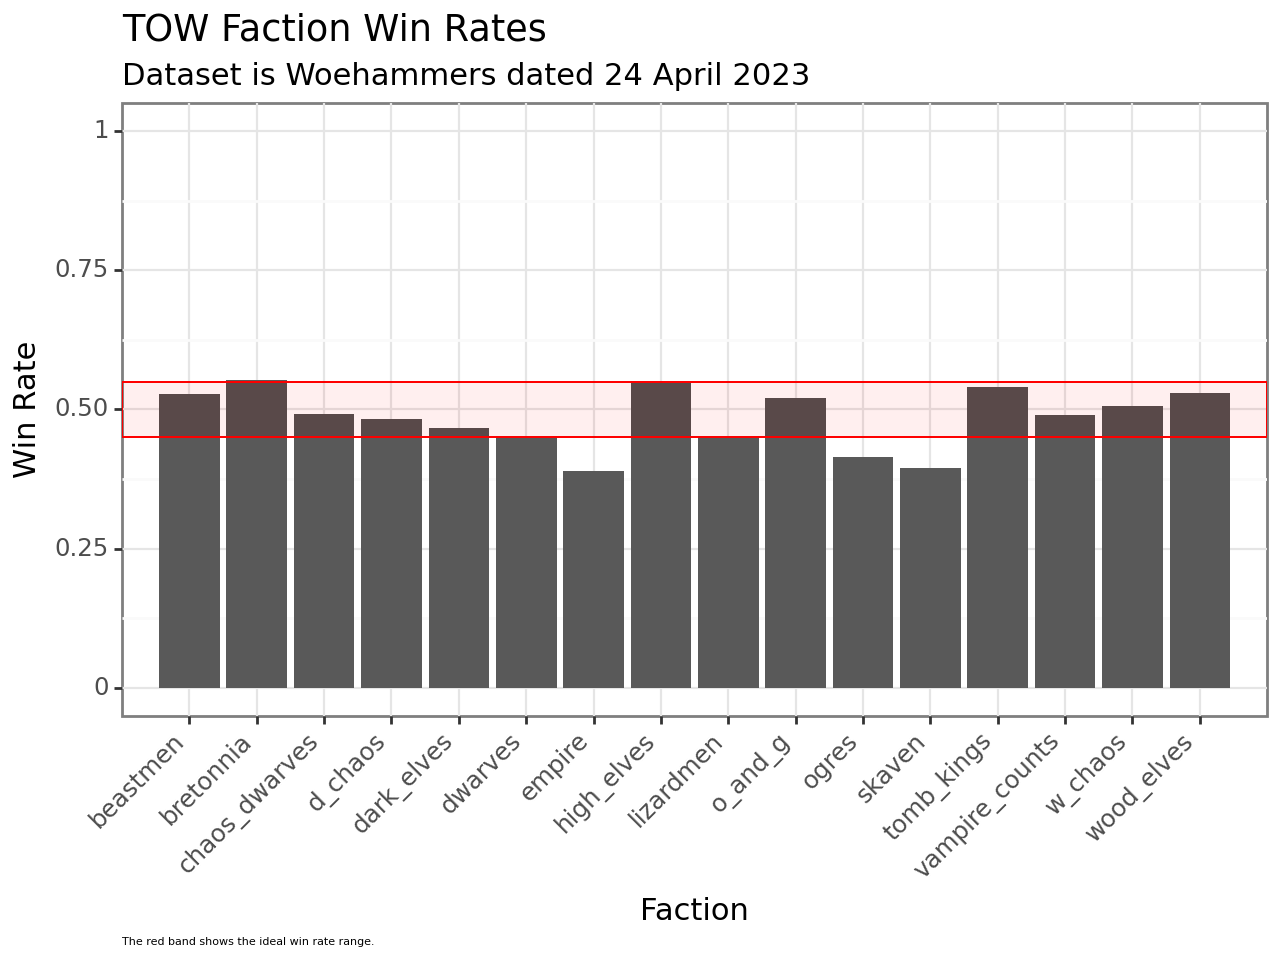

<Figure Size: (640 x 480)>

In [5]:
tow_faction_wr = tow_all_wr.groupby(['player_faction'])[['games_played', 'wins']].sum().reset_index()
tow_faction_wr['win_rate'] = tow_faction_wr['wins']/tow_faction_wr['games_played']
(
    ggplot(tow_faction_wr, aes(x='player_faction', y='win_rate'))
    + geom_bar(stat = "identity")
    + geom_rect(aes(xmin=0,xmax=17,ymin=0.45,ymax=0.55),color="red", fill="red", alpha=0.005, size=0.1)
    + theme_bw()
    + theme(axis_text_x = element_text(angle=45, hjust=1), plot_caption=element_text(ha="left", margin={"t": 1, "units": "lines"}, size=4), legend_position="none")
    + labs(title='TOW Faction Win Rates', subtitle='Dataset is Woehammers dated 24 April 2023', x='Faction', y='Win Rate', caption="The red band shows the ideal win rate range.")
    + scale_y_continuous(limits=(0, 1))
)

The bar chart gives a nice visualization of the faction win rates. We have four factions outside the accepted win rate range of 45%-55%: Bretonnia, Empire, Ogres, and Skaven.

### Logistic Model

Now it is time to build a model and see what insights we can get. First we will conduct a logistic regression on the initial dataset. Logistic regression is a statistical model that models the log-odds of an event as a linear combination of one or more independent variables. In other words, it will attempt to predict the probability of an outcome, in this case a win or a loss. The model will be: 'result ~ player_faction + C(rounds) + ruleset'. Rounds is identified as being a categorical variable.

What is shown is the final model selected. Points and players were removed during feature selection. Ties and one round tournaments are removed from the dataset due to small sample size.

In [6]:
log_df = player_db.query("result != 0.5 and rounds != 1")
y, X = dmatrices('result ~ player_faction + C(rounds) + ruleset', log_df, return_type='dataframe')

log_reg = sm.Logit(y, X).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.687374
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 result   No. Observations:                 2978
Model:                          Logit   Df Residuals:                     2960
Method:                           MLE   Df Model:                           17
Date:                Fri, 28 Jun 2024   Pseudo R-squ.:                0.008323
Time:                        14:11:55   Log-Likelihood:                -2047.0
converged:                       True   LL-Null:                       -2064.2
Covariance Type:            nonrobust   LLR p-value:                  0.007539
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.1315      0.168      0.782      0.434      -0.198       0.461
player_faction[T.bretonnia]          0.1000      0.196      0.511      0.610      -0.284       0.484
player_faction[T.chaos_dwarves]     -0.1565      0.311     -0.503      0.615      -0.766       0.453
player_faction[T.d_chaos]           -0.1942      0.272     -0.714      0.475      -0.727       0.339
player_faction[T.dark_elves]        -0.2688      0.243     -1.106      0.269      -0.745       0.208
player_faction[T.dwarves]           -0.3189      0.210     -1.522      0.128      -0.730       0.092
player_faction[T.empire]            -0.5976      0.214     -2.791      0.005      -1.017      -0.178
player_faction[T.high_elves]         0.0725      0.216      0.336      0.737      -0.351       0.496
player_faction[T.lizardmen]         -0.3216      0.277     -1.163      0.245      -0.864       0.220
player_faction[T.o_and_g]           -0.0282      0.201     -0.140      0.888      -0.423       0.366
player_faction[T.ogres]             -0.5094      0.276     -1.845      0.065      -1.051       0.032
player_faction[T.skaven]            -0.5805      0.277     -2.098      0.036      -1.123      -0.038
player_faction[T.tomb_kings]         0.0520      0.199      0.262      0.794      -0.337       0.441
player_faction[T.vampire_counts]    -0.1861      0.239     -0.779      0.436      -0.654       0.282
player_faction[T.w_chaos]           -0.0981      0.196     -0.501      0.616      -0.482       0.286
player_faction[T.wood_elves]         0.0046      0.215      0.021      0.983      -0.417       0.426
C(rounds)[T.5]                      -0.0199      0.092     -0.217      0.828      -0.200       0.160
ruleset[T.v1.2]                     -0.0108      0.083     -0.130      0.897      -0.174       0.152
====================================================================================================
"""

In [7]:
odds_ratios = pd.DataFrame(
    {
        "OR": log_reg.params,
        "Lower CI": log_reg.conf_int()[0],
        "Upper CI": log_reg.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)

odds_ratios.query("`Upper CI` <= 1.0")

,OR,Lower CI,Upper CI
player_faction[T.empire],0.550152,0.361620,0.836976
player_faction[T.skaven],0.559605,0.325314,0.962631


The model is a poor fit (Pseudo R-squared = 0.008) which means it does not explain the variance in the data. However, the model is significant (P-value < 0.05) which means there is a correlation between the independent and dependent variables. When we calculate the odds ratios, we see that the only variables that were significant in the model are also the only two variables where the Upper CI is less than 1.0 (Empire and Skaven). Both of their Odds Ratios are approximately 0.55 which means they are 50% less likely to win a match when compared to the other factions.

### Win Rate Visualizations

So by the logistic model, the only significant variables are the Empire and Skaven factions. But what if we look at win rates? Generally, win rates are considered a measure of performance since they take into account different population sizes (300 games played and 10 wins is very different from 20 games played and 10 wins).

We will start with a series of visualizations show the win rates by Points, Players, Rounds, and Ruleset. We will then develop a model to see what is significant to those win rates.

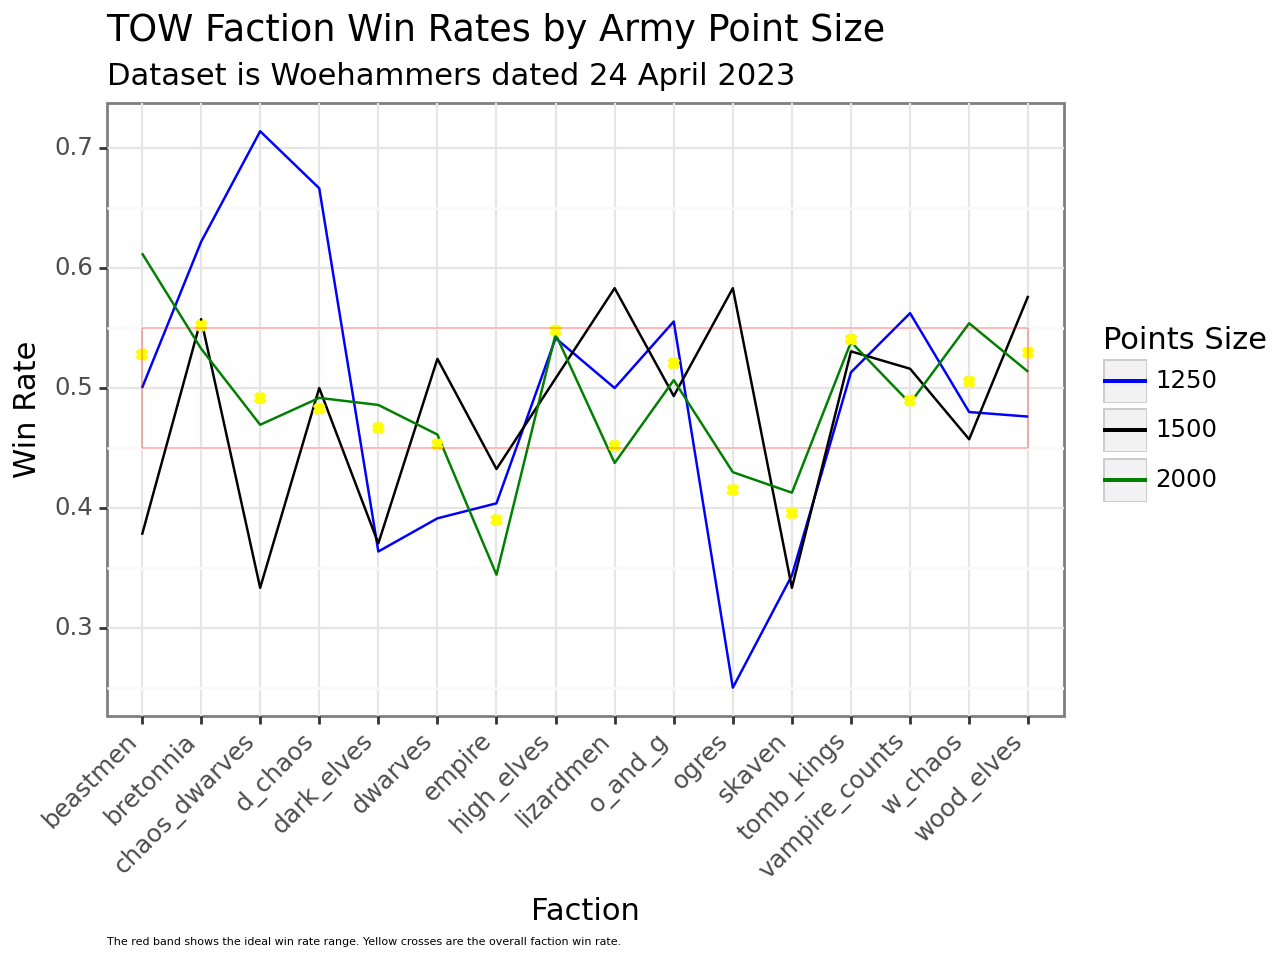

<Figure Size: (640 x 480)>

In [8]:
tow_points_wr = tow_all_wr.groupby(['player_faction', 'points'])[['games_played', 'wins']].sum().reset_index()
tow_points_wr['win_rate'] = tow_points_wr['wins']/tow_points_wr['games_played']
(
    ggplot()
    + geom_line(tow_points_wr.query("points == [2000, 1500, 1250]"), aes(x='player_faction', y='win_rate', group='points', color="factor(points)"))
    + geom_point(tow_faction_wr, aes(x='player_faction', y='win_rate'), color="yellow", shape='X')
    + geom_rect(aes(xmin=1,xmax=16,ymin=0.45,ymax=0.55),color="red", fill="red", alpha=0.005, size=0.1)
    + theme_bw()
    + theme(axis_text_x = element_text(angle=45, hjust=1), plot_caption=element_text(ha="left", margin={"t": 1, "units": "lines"}, size=4))
    + labs(title='TOW Faction Win Rates by Army Point Size', subtitle='Dataset is Woehammers dated 24 April 2023', x='Faction', y='Win Rate', color='Points Size', caption="The red band shows the ideal win rate range. Yellow crosses are the overall faction win rate.")
    + scale_color_manual(values=['blue', 'black', 'green'])
)

In [9]:
tow_all_wr.groupby(['players'])['player_faction'].count().sort_values(ascending=False).reset_index().head(3)

,players,player_faction
0,10,88
1,14,64
2,8,48


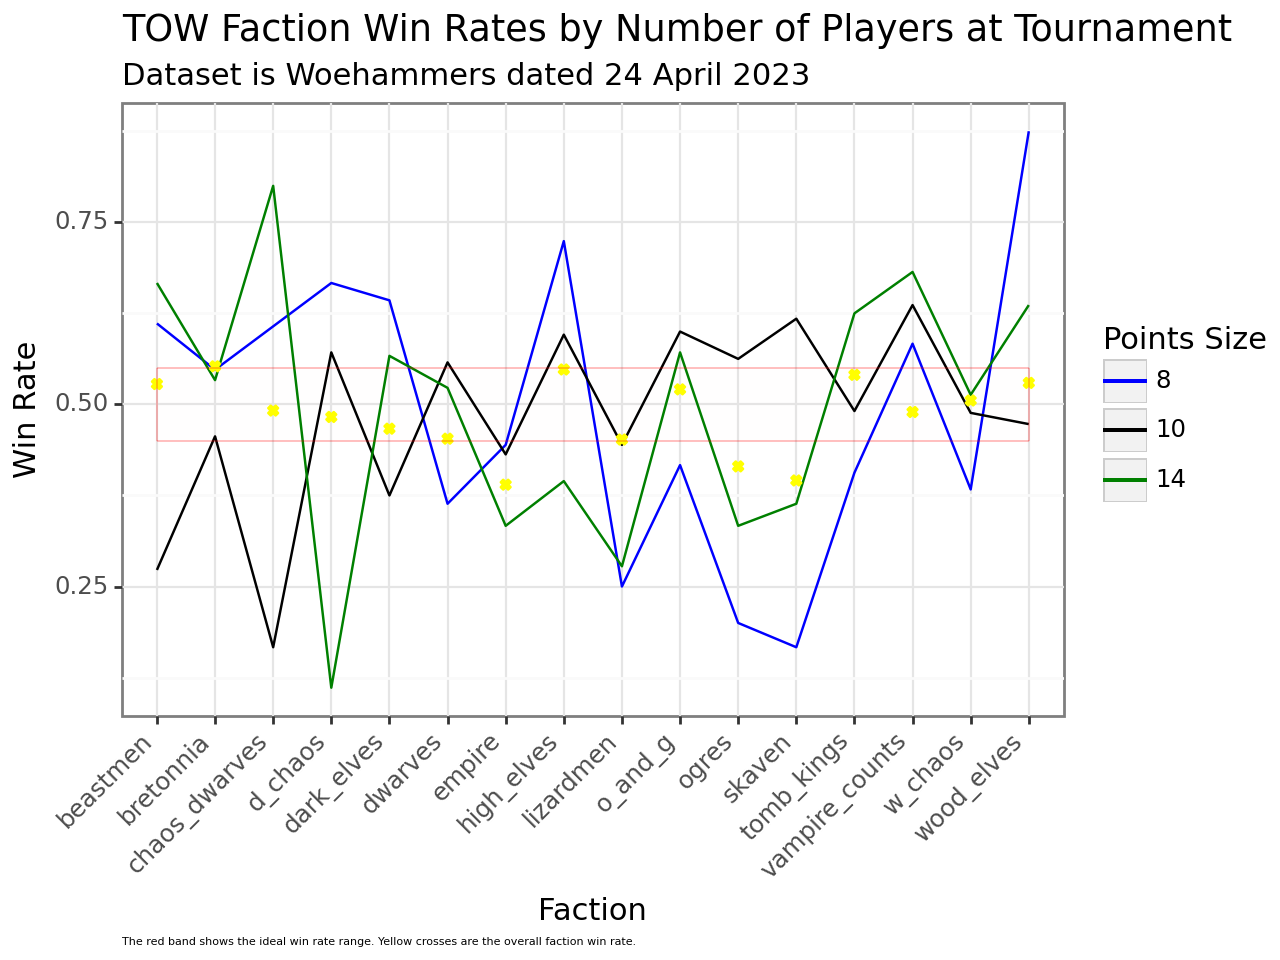

<Figure Size: (640 x 480)>

In [10]:
tow_player_wr = tow_all_wr.groupby(['player_faction', 'players'])[['games_played', 'wins']].sum().reset_index()
tow_player_wr['win_rate'] = tow_player_wr['wins']/tow_player_wr['games_played']
(
    ggplot()
    + geom_line(tow_player_wr.query("players == [8, 10, 14]"), aes(x='player_faction', y='win_rate', group='players', color="factor(players)"))
    + geom_point(tow_faction_wr, aes(x='player_faction', y='win_rate'), color="yellow", shape='X')
    # + geom_line(tow_faction_wr, aes(x='player_faction', y='win_rate'))
    + geom_rect(aes(xmin=1,xmax=16,ymin=0.45,ymax=0.55),color="red", fill="red", alpha=0.005, size=0.1)
    + theme_bw()
    + theme(axis_text_x = element_text(angle=45, hjust=1), plot_caption=element_text(ha="left", margin={"t": 1, "units": "lines"}, size=4))
    + labs(title='TOW Faction Win Rates by Number of Players at Tournament', subtitle='Dataset is Woehammers dated 24 April 2023', x='Faction', y='Win Rate', color='Points Size', caption="The red band shows the ideal win rate range. Yellow crosses are the overall faction win rate.")
    + scale_color_manual(values=['blue', 'black', 'green'])
)

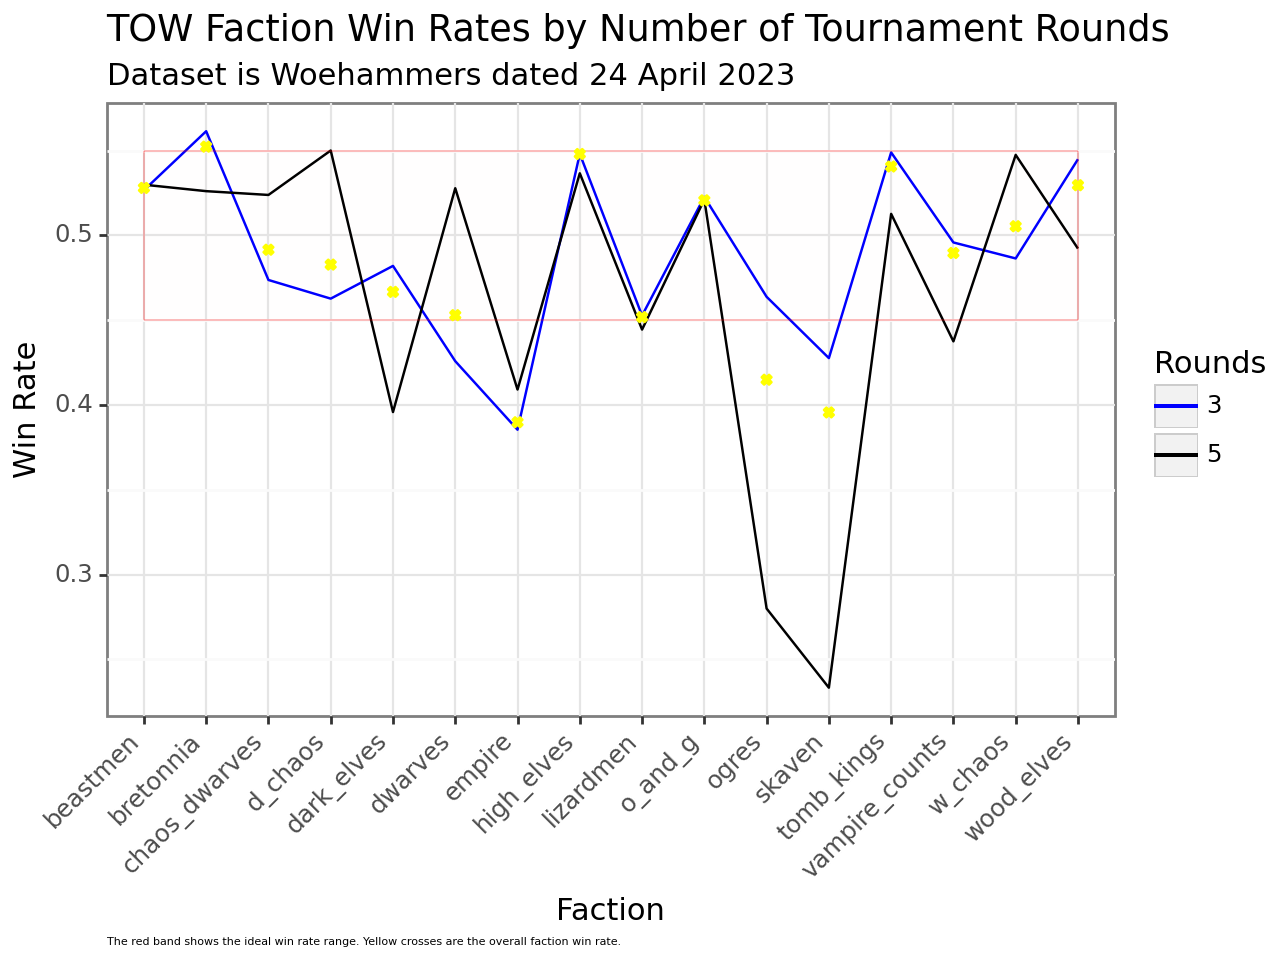

<Figure Size: (640 x 480)>

In [11]:
tow_rounds_wr = tow_all_wr.groupby(['player_faction', 'rounds'])[['games_played', 'wins']].sum().reset_index()
tow_rounds_wr['win_rate'] = tow_rounds_wr['wins']/tow_rounds_wr['games_played']
(
    ggplot()
    + geom_line(tow_rounds_wr.query("rounds != 1"), aes(x='player_faction', y='win_rate', group='rounds', color="factor(rounds)"))
    + geom_rect(aes(xmin=1,xmax=16,ymin=0.45,ymax=0.55),color="red", fill="red", alpha=0.005, size=0.1)
    + geom_point(tow_faction_wr, aes(x='player_faction', y='win_rate'), color="yellow", shape='X')
    + theme_bw()
    + theme(axis_text_x = element_text(angle=45, hjust=1), plot_caption=element_text(ha="left", margin={"t": 1, "units": "lines"}, size=4))
    + labs(title='TOW Faction Win Rates by Number of Tournament Rounds', subtitle='Dataset is Woehammers dated 24 April 2023', x='Faction', y='Win Rate', color='Rounds', caption="The red band shows the ideal win rate range. Yellow crosses are the overall faction win rate.")
    + scale_color_manual(values=['blue', 'black'])
)

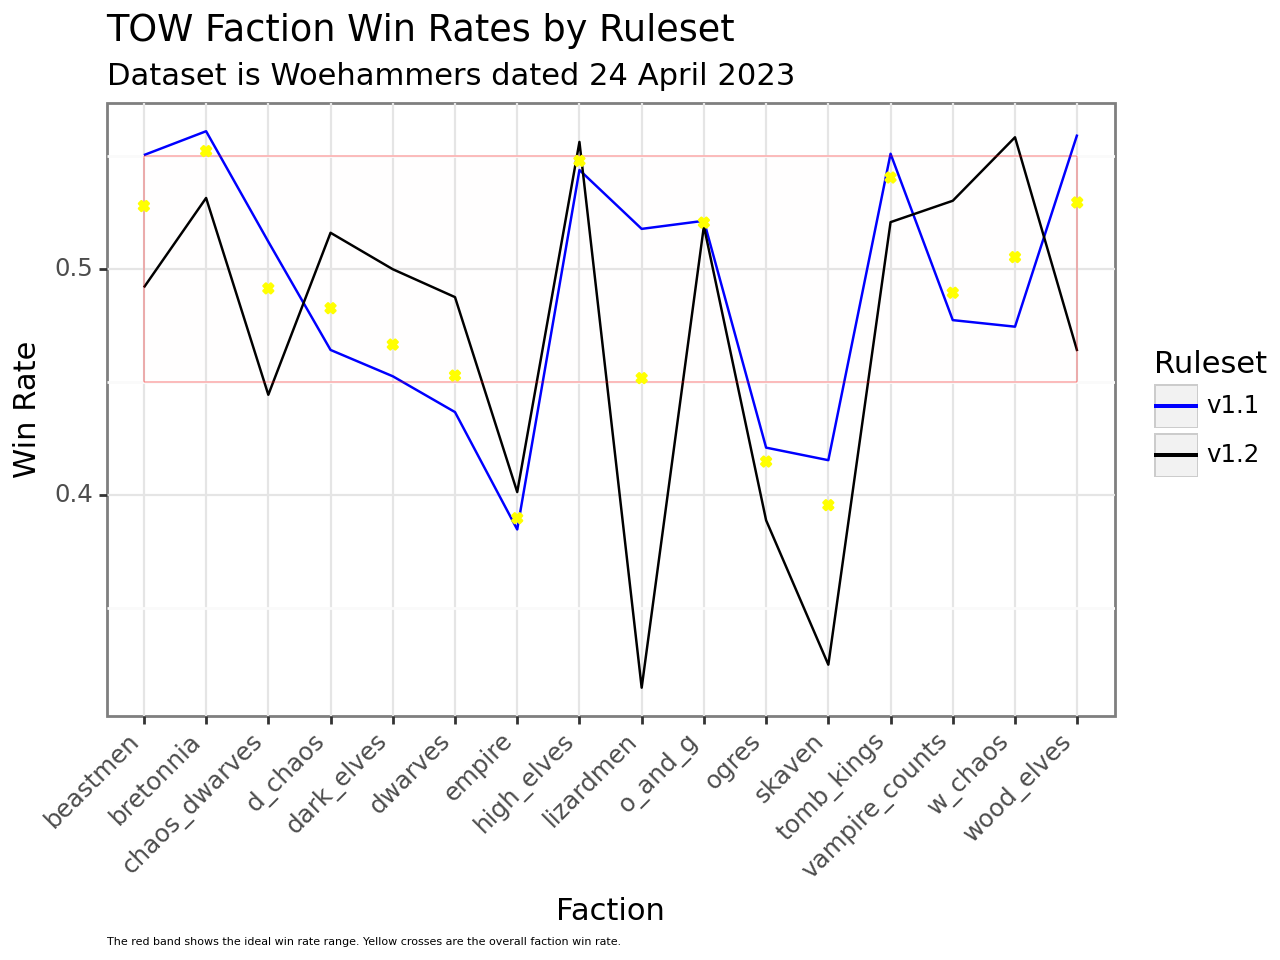

<Figure Size: (640 x 480)>

In [12]:
tow_ruleset_wr = tow_all_wr.groupby(['player_faction', 'ruleset'])[['games_played', 'wins']].sum().reset_index()
tow_ruleset_wr['win_rate'] = tow_ruleset_wr['wins']/tow_ruleset_wr['games_played']
(
    ggplot()
    + geom_line(tow_ruleset_wr, aes(x='player_faction', y='win_rate', group='ruleset', color='ruleset'))
    + geom_rect(aes(xmin=1,xmax=16,ymin=0.45,ymax=0.55),color="red", fill="red", alpha=0.005, size=0.1)
    + geom_point(tow_faction_wr, aes(x='player_faction', y='win_rate'), color="yellow", shape='X')
    + theme_bw()
    + theme(axis_text_x = element_text(angle=45, hjust=1), plot_caption=element_text(ha="left", margin={"t": 1, "units": "lines"}, size=4))
    + labs(title='TOW Faction Win Rates by Ruleset', subtitle='Dataset is Woehammers dated 24 April 2023', x='Faction', y='Win Rate', color='Ruleset', caption="The red band shows the ideal win rate range. Yellow crosses are the overall faction win rate.")
    + scale_color_manual(values=['blue', 'black'])
)

The visualizations above all generally show the same thing: most of the factions win rates fall within the accepted 45%-55% range.

### Win Rate Model

Now onto the model. Here we will build a Linear Regression model. Like with the logistic model, the model below has already gone through feature selection giving us: win_rate ~ player_faction + C(rounds) + ruleset. And once again, we will remove the one round tournaments due to their low sample size. 

In [13]:
linear_model_df = tow_all_wr.query("rounds != 1")
formula = 'win_rate ~ player_faction + C(rounds) + ruleset'
mod = smf.ols(formula, linear_model_df).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               win_rate   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     1.724
Date:                Fri, 28 Jun 2024   Prob (F-statistic):             0.0354
Time:                        14:11:56   Log-Likelihood:                -15.707
No. Observations:                 528   AIC:                             67.41
Df Residuals:                     510   BIC:                             144.3
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.5319      0.053     10.088      0.000       0.428       0.636
player_faction[T.bretonnia]          0.0220      0.063      0.352      0.725      -0.101       0.145
player_faction[T.chaos_dwarves]     -0.0068      0.087     -0.078      0.938      -0.178       0.165
player_faction[T.d_chaos]           -0.0462      0.078     -0.593      0.554      -0.199       0.107
player_faction[T.dark_elves]        -0.0189      0.070     -0.273      0.785      -0.155       0.118
player_faction[T.dwarves]           -0.0911      0.065     -1.403      0.161      -0.219       0.036
player_faction[T.empire]            -0.1283      0.066     -1.956      0.051      -0.257       0.001
player_faction[T.high_elves]        -0.0059      0.067     -0.088      0.930      -0.137       0.126
player_faction[T.lizardmen]         -0.1507      0.075     -2.010      0.045      -0.298      -0.003
player_faction[T.o_and_g]           -0.0338      0.064     -0.528      0.598      -0.159       0.092
player_faction[T.ogres]             -0.1007      0.076     -1.327      0.185      -0.250       0.048
player_faction[T.skaven]            -0.1690      0.075     -2.256      0.025      -0.316      -0.022
player_faction[T.tomb_kings]         0.0396      0.064      0.618      0.537      -0.086       0.166
player_faction[T.vampire_counts]    -0.0588      0.067     -0.872      0.383      -0.191       0.074
player_faction[T.w_chaos]           -0.0309      0.064     -0.482      0.630      -0.157       0.095
player_faction[T.wood_elves]         0.0223      0.067      0.334      0.739      -0.109       0.154
C(rounds)[T.5]                      -0.0056      0.033     -0.170      0.865      -0.070       0.059
ruleset[T.v1.2]                      0.0026      0.024      0.106      0.915      -0.045       0.050
==============================================================================
Omnibus:                        0.041   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.980   Jarque-Bera (JB):                0.081
Skew:                           0.020   Prob(JB):                        0.960
Kurtosis:                       2.954   Cond. No.                         21.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
win_rate_table = sm.stats.anova_lm(mod, typ=2)
win_rate_table

,sum_sq,df,F,PR(>F)
player_faction,1.884650,15.0,1.953041,0.016838
C(rounds),0.001854,1.0,0.028823,0.865256
ruleset,0.000725,1.0,0.011272,0.915491
Residual,32.809395,510.0,NaN,NaN


The linear model tells us a similar story to the logistic model from earlier. This model is a poor fit (R-squared = 0.05), not predictive (Adjusted R-squared = 0.02), but it is significant (Prob (F-statistic) < 0.05). Our significant variables are Lizardmen and Skaven (both with negative coefficients) and the ANOVA table shows that only the player faction variable, as a whole, is significant to win rates.

## Summary

Here are the takeaways from our analysis:
* 11 of the 16 factions have an overall win rate within the accepted 45%-55% range
    * 3 of the 4 factions that are outside the accepted range (Empire, Skaven, Ogres) are below 45%
    * Bretonnia is the only faction above 55%
* Of the five independent variables we looked at (player_faction, rounds, points, players, ruleset):
    * Points and players were not used in either model
    * Player_faction, rounds, and ruleset were used in both models
* Skaven were identified as significant in both models; the logistic model also showed Empire as significant whereas the linear model also showed Lizardmen as significant
* While both rounds and ruleset were included in the models, neither were identified as significant.

Overall, the factions are what primarily drive the wins/win rates. The point sizes or number of players in a tournament do not contribute. And while the number of rounds and ruleset do contribute, they are not themselves statistically different from their separate values (i.e. win rates at 5 round tournaments are no different from win rates at 3 round tournaments).